## Import library

In [ ]:
import joblib
import re
!pip install sklearn
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import scipy.sparse

import bs4 as bs  
import re  
from sklearn.metrics import classification_report, make_scorer

from sklearn.metrics import f1_score,balanced_accuracy_score,accuracy_score

import warnings
warnings.filterwarnings("ignore")

import itertools
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
from sklearn.base import clone
import time

In [ ]:
import pandas as pd
import numpy as np  
import random  
import string
import unicodedata
import matplotlib.pyplot as plt

In [ ]:
dc = {
  "listedAt": "2020-07-11T01:08:58+07:00",
  "lastCheckedAt": "2021-04-13T14:48:37.967756+07:00",
  "scrapBuildingType": "house",
  "latitude": -7.893,
  "longitude": 110.14299999999999,
  "url": "https://www.olx.co.id/item/jual-pendopo-joglo-kayu-jati-ukir,-rumah-joglo-gebyok,-rumah-limasan-iid-790272511",
  "price": 151000000,
  "scrapSource": "olx",
  "description": "Produksi Pendopo dan Rumah joglo gebyok ukir Bahan Kayu jati Luas joglo pendopo 10X 8 M luas luar lunas 10X12 Meter Soko guru 20x20x380 Bentangan 225x380cm Blandar pracik 12x10cm Soko pracik12x12x300cm Usuk 4x10cm Tumpang dalam 7 Tumpang luar 3 Plafon triplek Genteng mantili Lisplang keliling Umpak Batu candi Tidak termasuk Tanah pondasi dan lantai Harga Pendopo tanpa dinding 150 jt Sudah sampai pemasangan Barang ready Rumah Joglo dengan ukuran 8mx10m luas dalam dg teras depan 2 meter 10x10 meter luas dalam 12x12 luas luar Dengan gebyok depan ukir 10 meter dan dinding papan kanan kiri dan belakang plus sekat papan panel 2 kamar Harga 260 Juta Limasan soko guru 20x20x400cm 8btng midangan 14x20cm sunduk 17x17cm soko pracik 12x12x300cm usuk 4x10cm plafol triplek 6mm Luas 9x12 meter 145jt Tidak termasuk dinding dan lantai Showroom Galeri Omah Joglo Jalan Raya Ngabul km 9 Tahunan Jepara",
  "externalPropertyID": "790272511",
  "scrapStatus": "active",
  "delistedAt": 'null',
  "scrapMarketType": "second",
  "scrapAssignedCity": "Kulon Progo",
  "propertyAttr": {
    "surfaceArea": 80,
    "buildingArea": 120,
    "electricalCapacity": 'null',
    "totalFloors": 0,
    "parkingCapacity": 0,
    "bedroom": 1,
    "bathroom": 1,
    "facilities": ["garden"],
    "agentID": "89457251",
    "agentName": "Saeful"
  }
}

In [ ]:
dc.get('propertyAttr').get('totalFloors')

0

In [ ]:
print ('True' if dc['propertyAttr']['totalFloors'] else 'False')

False


In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,LSTM, Activation,Bidirectional, GlobalMaxPool1D
from keras.layers.core import Reshape, Flatten
from keras.models import Model

# Sentiment

## Cleaning

In [ ]:
data = pd.read_excel('/content/data_topic.xlsx')
stop_words = open("/content/stopword.txt", "r").read().split()
dic = pd.read_csv('/content/normalize_word.csv')

In [ ]:
data.loc[data[data['Label Topic Classification'] == 7].index,'Label Topic Classification']=12
data.loc[data[data['Label Topic Classification'] == 8].index,'Label Topic Classification']=4
data.loc[data[data['Label Topic Classification'] == 5].index,'Label Topic Classification']=10

In [ ]:
def normalize(text):
    text = text.split()
    for val in dic.itertuples(index=False):
        text = [w.replace(val.slang, val.formal) if w == val.slang else w for w in text]
    return " ".join(text)

In [ ]:
# bersihkan teks
def clean_text(text,stopwords):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = ' '.join([word for word in text.split() if word.lower() not in stopwords])
    return text
data['content'] = data['content'].apply(clean_text,stopwords=stop_words)

In [ ]:
%%time
# df.apply(some_func, var1='DOG', axis=1)
data['content'] = data['content'].apply(clean_text,stopwords=stop_words)
data['content'] = data['content'].apply(normalize)

CPU times: user 1min 8s, sys: 96.7 ms, total: 1min 8s
Wall time: 1min 8s


In [ ]:
def checkLen(data):
  return len(data.split())
data['Len'] = data['content'].apply(checkLen)

In [ ]:
len(data)

625

In [ ]:
data = data[data['Len'] > 10].reset_index(drop=True)

In [ ]:
len(data)

619

In [ ]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.8

df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 495
TEST size: 124


## Feature Extraction

In [ ]:
# data = dataCheck.copy()
# # Ubah fitur menjadi bentuk TFIDF dengan jumlah kata 150
mx_feat = 1000
vectorizer = CountVectorizer(max_features=mx_feat)
bow_data_train = vectorizer.fit_transform(df_train['content'])
bow_data_train = pd.DataFrame.sparse.from_spmatrix(bow_data_train,columns=vectorizer.get_feature_names())

bow_data_test = vectorizer.transform(df_test['content'])
bow_data_test = pd.DataFrame.sparse.from_spmatrix(bow_data_test,columns=vectorizer.get_feature_names())
# data = data.join(bow_data)

In [ ]:
joblib.dump(vectorizer, 'CountVectorizerTopic.pkl')

['CountVectorizerTopic.pkl']

## Modeling

In [ ]:
# Metrics
from sklearn.metrics import accuracy_score

In [ ]:
x_train = bow_data_train.values
x_test = bow_data_test.values

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
encoder.fit(df_train['Label Topic Classification'].values.reshape(-1,1))

y_train = encoder.transform(df_train['Label Topic Classification'].values.reshape(-1,1))
y_test = encoder.transform(df_test['Label Topic Classification'].values.reshape(-1,1))

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (495, 9)
y_test (124, 9)


In [ ]:
dropout = 0.1
def make_nn(dropout):
  inputs = Input(shape=(mx_feat,))
  layer = Dense(32, activation="relu")(inputs)
  layer = Dense(32, activation="relu")(layer)
  layer = Dropout(dropout)(layer)
  layer = Dense(9, activation="softmax")(layer)
  model = Model(inputs, layer)
  return model
model = make_nn(dropout)

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 10))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-6), metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=8, epochs=70, callbacks=[lr_schedule],verbose=1)

Epoch 1/70
62/62 [==============================] - 1s 6ms/step - loss: 0.7816 - accuracy: 0.1328 - val_loss: 0.7646 - val_accuracy: 0.1210
Epoch 2/70
62/62 [==============================] - 0s 2ms/step - loss: 0.7767 - accuracy: 0.1269 - val_loss: 0.7634 - val_accuracy: 0.1210
Epoch 3/70
62/62 [==============================] - 0s 2ms/step - loss: 0.7758 - accuracy: 0.1162 - val_loss: 0.7618 - val_accuracy: 0.1210
Epoch 4/70
62/62 [==============================] - 0s 2ms/step - loss: 0.7640 - accuracy: 0.1767 - val_loss: 0.7600 - val_accuracy: 0.1210
Epoch 5/70
62/62 [==============================] - 0s 2ms/step - loss: 0.7618 - accuracy: 0.1456 - val_loss: 0.7577 - val_accuracy: 0.1210
Epoch 6/70
62/62 [==============================] - 0s 2ms/step - loss: 0.7650 - accuracy: 0.1563 - val_loss: 0.7547 - val_accuracy: 0.1210
Epoch 7/70
62/62 [==============================] - 0s 2ms/step - loss: 0.7555 - accuracy: 0.1414 - val_loss: 0.7511 - val_accuracy: 0.1210
Epoch 8/70
62/62 [==

(1e-06, 1.0, 0.0, 2.0)

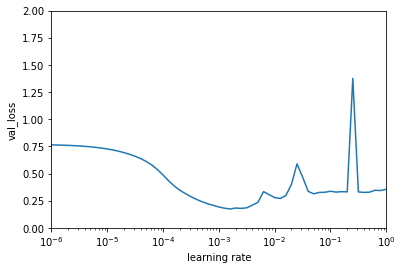

In [ ]:
plt.xlabel('learning rate')
plt.ylabel('val_loss')
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e0, 0, 2])

In [ ]:
model = make_nn(dropout)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=4*1e-4), metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=8, epochs=20,verbose=1)

Epoch 1/20
62/62 [==============================] - 1s 6ms/step - loss: 0.6332 - accuracy: 0.0940 - val_loss: 0.4535 - val_accuracy: 0.2258
Epoch 2/20
62/62 [==============================] - 0s 2ms/step - loss: 0.4290 - accuracy: 0.2358 - val_loss: 0.3401 - val_accuracy: 0.3952
Epoch 3/20
62/62 [==============================] - 0s 2ms/step - loss: 0.3365 - accuracy: 0.3738 - val_loss: 0.2866 - val_accuracy: 0.5484
Epoch 4/20
62/62 [==============================] - 0s 2ms/step - loss: 0.2691 - accuracy: 0.5311 - val_loss: 0.2559 - val_accuracy: 0.6613
Epoch 5/20
62/62 [==============================] - 0s 2ms/step - loss: 0.2298 - accuracy: 0.6626 - val_loss: 0.2297 - val_accuracy: 0.7177
Epoch 6/20
62/62 [==============================] - 0s 2ms/step - loss: 0.2051 - accuracy: 0.7131 - val_loss: 0.2119 - val_accuracy: 0.7258
Epoch 7/20
62/62 [==============================] - 0s 2ms/step - loss: 0.1676 - accuracy: 0.7952 - val_loss: 0.1977 - val_accuracy: 0.7419
Epoch 8/20
62/62 [==

In [ ]:
pred = model.predict(x_test)

In [ ]:
accuracy_score(np.argmax(pred, axis=1),np.argmax(y_test, axis=1))

0.8064516129032258

In [ ]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [ ]:
!zip -r '/content/model.zip' '/content/model'

  adding: content/model/ (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 88%)
  adding: content/model/keras_metadata.pb (deflated 87%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 63%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 8%)


# ML 2

## Cleaning

In [ ]:
import pandas as pd

data = pd.read_excel('../Data/data_baru.xlsx')
stop_words = open("../Data/stopword.txt", "r").read().split()
dic = pd.read_csv('../Data/normalize_word.csv')

In [ ]:
data = pd.read_excel('/content/data_topic.xlsx')
stop_words = open("/content/stopword.txt", "r").read().split()
dic = pd.read_csv('/content/normalize_word.csv')

In [ ]:
data.loc[data[data['Label Topic Classification'] == 7].index,'Label Topic Classification']=12
data.loc[data[data['Label Topic Classification'] == 8].index,'Label Topic Classification']=4
data.loc[data[data['Label Topic Classification'] == 5].index,'Label Topic Classification']=10

In [ ]:
def normalize(text):
    text = text.split()
    for val in dic.itertuples(index=False):
        text = [w.replace(val.slang, val.formal) if w == val.slang else w for w in text]
    return " ".join(text)

In [ ]:
import re
import string

# bersihkan teks
def clean_text(text,stopwords):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = ' '.join([word for word in text.split() if word.lower() not in stopwords])
    return text
data['content'] = data['content'].apply(clean_text,stopwords=stop_words)

In [ ]:
%%time
data['content'] = data['content'].apply(clean_text, stopwords=stop_words)
data['content'] = data['content'].apply(normalize)

CPU times: user 1min 8s, sys: 107 ms, total: 1min 8s
Wall time: 1min 8s


In [ ]:
def checkLen(data):
  return len(data.split())
data['Len'] = data['content'].apply(checkLen)

In [ ]:
len(data)

625

In [ ]:
data = data[data['Len'] > 10].reset_index(drop=True)

In [ ]:
len(data)

619

In [ ]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.8

df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 495
TEST size: 124


## Word2vec

In [ ]:
%%time
documents = [_content.split() for _content in df_train.content] 

CPU times: user 12.5 ms, sys: 0 ns, total: 12.5 ms
Wall time: 16.2 ms


In [ ]:
import gensim

# WORD2VEC 
W2V_SIZE = 200
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)


In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2285


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 8.21 s, sys: 99.2 ms, total: 8.3 s
Wall time: 4.58 s


(2434697, 3501856)

In [ ]:
w2v_model.most_similar("jakarta")


[('merdeka', 0.6369597911834717),
 ('medan', 0.5701730251312256),
 ('pemprov', 0.509030282497406),
 ('rabu', 0.49615195393562317),
 ('–', 0.49082109332084656),
 ('balai', 0.48216354846954346),
 ('kalimantan', 0.4512553811073303),
 ('sulawesi', 0.4496494233608246),
 ('riza', 0.4436049461364746),
 ('selasa', 0.43577930331230164)]

In [ ]:
%%time

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.content)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 14976
CPU times: user 142 ms, sys: 87.5 ms, total: 229 ms
Wall time: 151 ms


In [ ]:
%%time

from keras.preprocessing.sequence import pad_sequences

# KERAS
SEQUENCE_LENGTH = 200

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.content), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.content), maxlen=SEQUENCE_LENGTH)

CPU times: user 88.4 ms, sys: 6.07 ms, total: 94.5 ms
Wall time: 91 ms


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
encoder.fit(df_train['Label Topic Classification'].values.reshape(-1,1))

y_train = encoder.transform(df_train['Label Topic Classification'].values.reshape(-1,1))
y_test = encoder.transform(df_test['Label Topic Classification'].values.reshape(-1,1))

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (495, 9)
y_test (124, 9)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (495, 200)
y_train (495, 9)

x_test (124, 200)
y_test (124, 9)


In [ ]:
import numpy as np

embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(14976, 200)


## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

model = Sequential()
model.add(Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 200)          2995200   
_________________________________________________________________
dropout_31 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_107 (Dense)            (None, 9)                 909       
Total params: 3,116,509
Trainable params: 121,309
Non-trainable params: 2,995,200
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [ ]:
%%time
import tensorflow as tf

EPOCHS = 60
BATCH_SIZE = 8

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 10), verbose=1)

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=[lr_schedule],
                    verbose=1)

Epoch 1/60

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
56/56 [==============================] - 75s 315ms/step - loss: 2.2394 - acc: 0.0746 - val_loss: 2.1918 - val_acc: 0.1800
Epoch 2/60

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2589254117941672e-06.
56/56 [==============================] - 17s 304ms/step - loss: 2.2392 - acc: 0.0921 - val_loss: 2.1900 - val_acc: 0.1800
Epoch 3/60

Epoch 00003: LearningRateScheduler reducing learning rate to 1.5848931924611134e-06.
56/56 [==============================] - 17s 304ms/step - loss: 2.2217 - acc: 0.1003 - val_loss: 2.1877 - val_acc: 0.1800
Epoch 4/60

Epoch 00004: LearningRateScheduler reducing learning rate to 1.9952623149688796e-06.
56/56 [==============================] - 17s 299ms/step - loss: 2.1983 - acc: 0.1066 - val_loss: 2.1848 - val_acc: 0.1800
Epoch 5/60

Epoch 00005: LearningRateScheduler reducing learning rate to 2.51188643150958e-06.
56/56 [==============================] - 17s 3

(1e-06, 1.0, 0.0, 2.0)

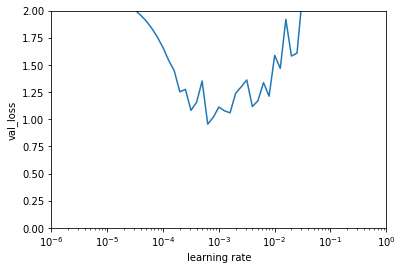

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel('learning rate')
plt.ylabel('val_loss')
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e0, 0, 2])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=6*1e-4), metrics=['accuracy'])

history = model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=8, epochs=10,verbose=1)

Epoch 1/10
62/62 [==============================] - 24s 330ms/step - loss: 0.5856 - accuracy: 0.1178 - val_loss: 0.3098 - val_accuracy: 0.3145
Epoch 2/10
62/62 [==============================] - 19s 313ms/step - loss: 0.3116 - accuracy: 0.3321 - val_loss: 0.2542 - val_accuracy: 0.4839
Epoch 3/10
62/62 [==============================] - 20s 317ms/step - loss: 0.2644 - accuracy: 0.4877 - val_loss: 0.2392 - val_accuracy: 0.5000
Epoch 4/10
62/62 [==============================] - 19s 309ms/step - loss: 0.2334 - accuracy: 0.5801 - val_loss: 0.2008 - val_accuracy: 0.6694
Epoch 5/10
62/62 [==============================] - 19s 312ms/step - loss: 0.2114 - accuracy: 0.6386 - val_loss: 0.1831 - val_accuracy: 0.7016
Epoch 6/10
62/62 [==============================] - 20s 316ms/step - loss: 0.1906 - accuracy: 0.6658 - val_loss: 0.1955 - val_accuracy: 0.6290
Epoch 7/10
62/62 [==============================] - 20s 317ms/step - loss: 0.2005 - accuracy: 0.6794 - val_loss: 0.1728 - val_accuracy: 0.7258

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

16/16 [==============================] - 1s 36ms/step - loss: 0.1714 - accuracy: 0.6855

ACCURACY: 0.6854838728904724
LOSS: 0.17135639488697052
CPU times: user 1.08 s, sys: 19.6 ms, total: 1.1 s
Wall time: 637 ms
